In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import os


In [3]:
# !pip install --upgrade scikit-learn==1.7.2
# import sklearn
# print(sklearn.__version__)
# !pip install --upgrade lightgbm
print(lgb.__version__)

4.6.0


In [4]:

print("Loading data...")

# Auto-detect Kaggle environment
if os.path.exists("/kaggle/input"):
    TRAIN_TRANS = "/kaggle/input/ieee-fraud-detection/train_transaction.csv"
    TRAIN_IDENT = "/kaggle/input/ieee-fraud-detection/train_identity.csv"
else:
    TRAIN_TRANS = "train_transaction.csv"
    TRAIN_IDENT = "train_identity.csv"

train_tr = pd.read_csv(TRAIN_TRANS, index_col="TransactionID")
train_id = pd.read_csv(TRAIN_IDENT, index_col="TransactionID")

train = train_tr.merge(train_id, how="left", left_index=True, right_index=True)

# target
y = train["isFraud"]
X = train.drop("isFraud", axis=1)

# ---------------------------
#  Feature list
# ---------------------------
new_features = [
            "TransactionID",
            "TransactionAmt",
            "DeviceInfo",
            "TransactionDT",
            "ProductCD",
            "card1",
            "card2",
            "card3",
            "card4",
            "card5",
            "card6",
            "addr1",
            "addr2",
            "dist1",
            "dist2",
            "P_emaildomain",
            "R_emaildomain",
        ]

# ---------------------------
#  Use these features for better performance and above for reasonable and fast performance
# ---------------------------
# new_features = [
#     'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5', 'card6',
#     'addr1', 'addr2', 'dist1', 'dist2',
#     'P_emaildomain', 'R_emaildomain',
#     'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
#     'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
#     'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8', 'M9',
#     'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 
#     'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56',
#     'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86',
#     'V88', 'V89', 'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
#     'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139', 'V142',
#     'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V173',
#     'V175', 'V176', 'V178', 'V180', 'V182', 'V185', 'V187', 'V188', 'V198',
#     'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221',
#     'V223', 'V224', 'V226', 'V228', 'V229', 'V234', 'V235', 'V238', 'V240',
#     'V250', 'V252', 'V253', 'V257', 'V258', 'V260', 'V261', 'V264', 'V266',
#     'V267', 'V271', 'V274', 'V277', 'V281', 'V283', 'V284', 'V285', 'V286',
#     'V289', 'V291', 'V294', 'V296', 'V297', 'V301', 'V303', 'V305', 'V307',
#     'V309', 'V310', 'V314', 'V320',
#     'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10',
#     'id_11', 'id_12', 'id_13', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
#     'id_20', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37', 'id_38',
#     'DeviceType', 'DeviceInfo'
# ]
# Filter only available columns
features = [f for f in new_features if f in X.columns]
X = X[features]

# ---------------------------
# Fill NA
# ---------------------------
X = X.fillna(-999)

# ---------------------------
# Label Encoding
# ---------------------------
label_encoders = {}

for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(features, "model_features.pkl")

# ---------------------------
# Train/Val Split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# LightGBM Model
# ---------------------------
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_val, label=y_val)


Loading data...


In [ ]:

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 128,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "verbosity": -1,
}

model = lgb.train(
    params,
    train_ds,
    valid_sets=[train_ds, val_ds],
    num_boost_round=4000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=300),
        lgb.log_evaluation(period=200)
    ]
)


model.save_model("ieee_lgbm.txt")
# Evaluate Validation AUC
val_pred = model.predict(X_val)
auc = roc_auc_score(y_val, val_pred)
print("Validation AUC:", auc)
print("MODEL TRAINED AND SAVED SUCCESSFULLY!")

In [6]:
def get_tree_depth(tree_structure):
    if "left_child" not in tree_structure and "right_child" not in tree_structure:
        return 1

    left_depth = right_depth = 0

    if "left_child" in tree_structure:
        left_depth = get_tree_depth(tree_structure["left_child"])
    if "right_child" in tree_structure:
        right_depth = get_tree_depth(tree_structure["right_child"])

    return 1 + max(left_depth, right_depth)


# Collect depths
model_json = model.dump_model()
tree_depths = []

for tree in model_json["tree_info"]:
    depth = get_tree_depth(tree["tree_structure"])
    tree_depths.append(depth)

# Statistics
max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print("\n--- Depth Summary ---")
print(f"Max depth: {max_depth}")
print(f"Min depth: {min_depth}")
print(f"Average depth: {avg_depth:.2f}")



--- Depth Summary ---
Max depth: 41
Min depth: 13
Average depth: 20.97


In [ ]:
# Auto-detect Kaggle
if os.path.exists("/kaggle/input"):
    TEST_TRANS = "/kaggle/input/ieee-fraud-detection/test_transaction.csv"
    TEST_IDENT = "/kaggle/input/ieee-fraud-detection/test_identity.csv"
else:
    TEST_TRANS = "test_transaction.csv"
    TEST_IDENT = "test_identity.csv"

# Load test data
test_tr = pd.read_csv(TEST_TRANS, index_col="TransactionID")
test_id = pd.read_csv(TEST_IDENT, index_col="TransactionID")
test = test_tr.merge(test_id, how="left", left_index=True, right_index=True)

MODEL_PATH = "/kaggle/working/ieee_lgbm.txt"
FEATURES_PATH = "/kaggle/working/model_features.pkl"
ENCODERS_PATH = "/kaggle/working/label_encoders.pkl"

model = lgb.Booster(model_file=MODEL_PATH)
features = joblib.load(FEATURES_PATH)
label_encoders = joblib.load(ENCODERS_PATH)


# -----------------------------
# Choose only a subset of features for testing
# -----------------------------
selected_features = [
            "TransactionID",
            "TransactionAmt",
            "DeviceInfo",
            "TransactionDT",
            "ProductCD",
            "card1",
            "card2",
            "card3",
            "card4",
            "card5",
            "card6",
            "addr1",
            "addr2",
            "dist1",
            "dist2",
            "P_emaildomain",
            "R_emaildomain",
        ]

# Keep only features that exist in test
existing_features = [f for f in selected_features if f in test.columns]
X_test = test[existing_features].copy()

# -----------------------------
# Preprocess categorical features
# -----------------------------
for col in X_test.columns:
    if col in label_encoders:
        le = label_encoders[col]
        # Replace unseen labels with a placeholder
        X_test[col] = X_test[col].astype(str).map(lambda x: x if x in le.classes_ else "unseen_before_label")
        # Refit the encoder to include the placeholder if missing
        if "unseen_before_label" not in le.classes_:
            le_classes = list(le.classes_) + ["unseen_before_label"]
            le.classes_ = np.array(le_classes)
        X_test[col] = le.transform(X_test[col])

# -----------------------------
# Fill missing numeric features with -999
# -----------------------------
for col in X_test.columns:
    if col not in label_encoders:  # numeric
        X_test[col] = X_test[col].fillna(-999)

# -----------------------------
# Make predictions
# -----------------------------
preds = model.predict(X_test)
auc = roc_auc_score(y_val, preds)
# submission = pd.DataFrame({
#     "TransactionID": X_test.index,
#     "isFraud": preds
# })

# submission.to_csv("submission.csv", index=False)
# print("Saved submission.csv")


Loading data...
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.94068	train's binary_logloss: 0.0854263	valid's auc: 0.913912	valid's binary_logloss: 0.0959441
[400]	train's auc: 0.966935	train's binary_logloss: 0.0712527	valid's auc: 0.931471	valid's binary_logloss: 0.086527
[600]	train's auc: 0.980516	train's binary_logloss: 0.0615152	valid's auc: 0.941028	valid's binary_logloss: 0.0805787
[800]	train's auc: 0.987849	train's binary_logloss: 0.0540769	valid's auc: 0.945804	valid's binary_logloss: 0.0765192
[1000]	train's auc: 0.992008	train's binary_logloss: 0.0480073	valid's auc: 0.949551	valid's binary_logloss: 0.0731463
[1200]	train's auc: 0.995008	train's binary_logloss: 0.042838	valid's auc: 0.952272	valid's binary_logloss: 0.0704981
[1400]	train's auc: 0.996736	train's binary_logloss: 0.0385599	valid's auc: 0.954013	valid's binary_logloss: 0.0683791
[1600]	train's auc: 0.997865	train's binary_logloss: 0.0348748	valid's auc: 0.955349	valid's bin

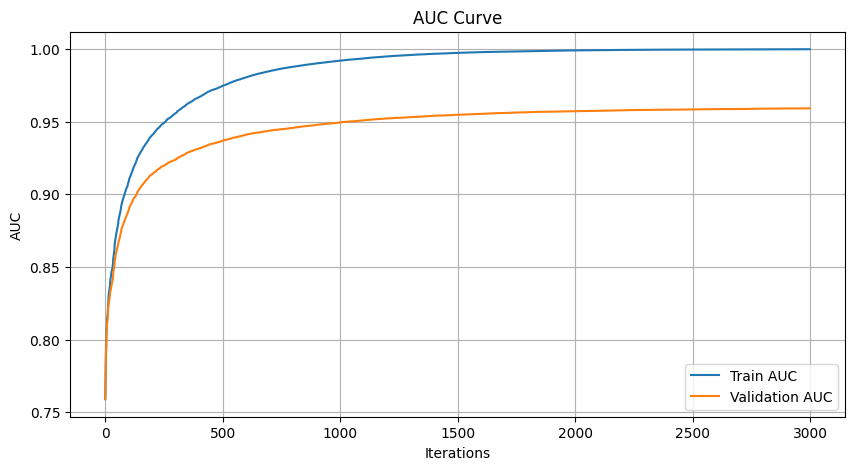

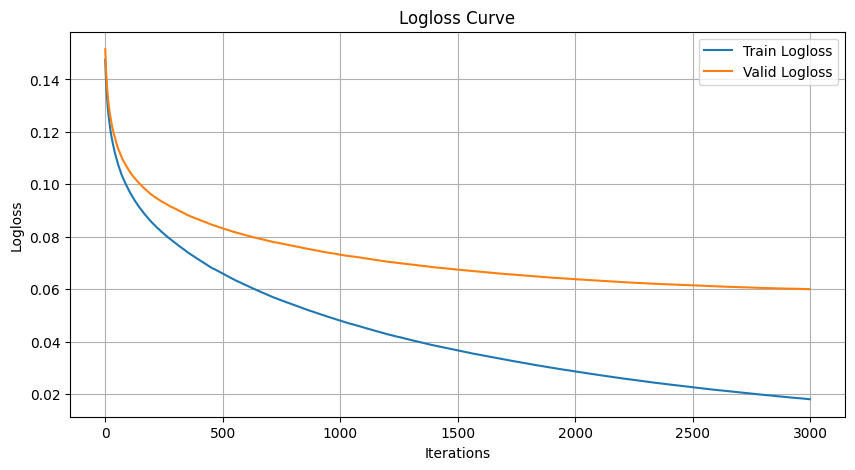

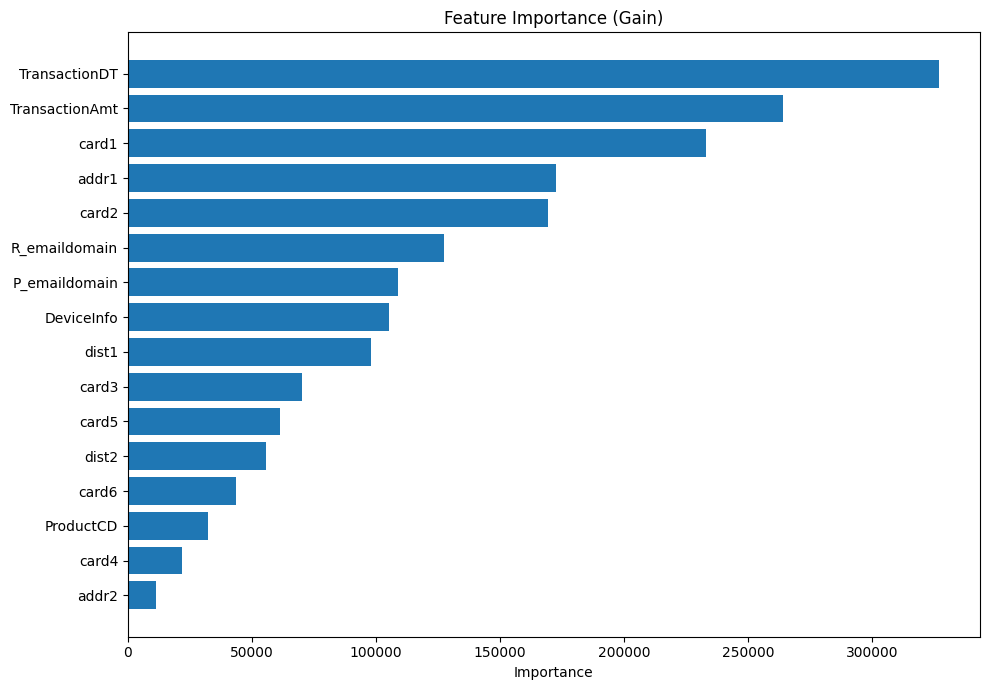

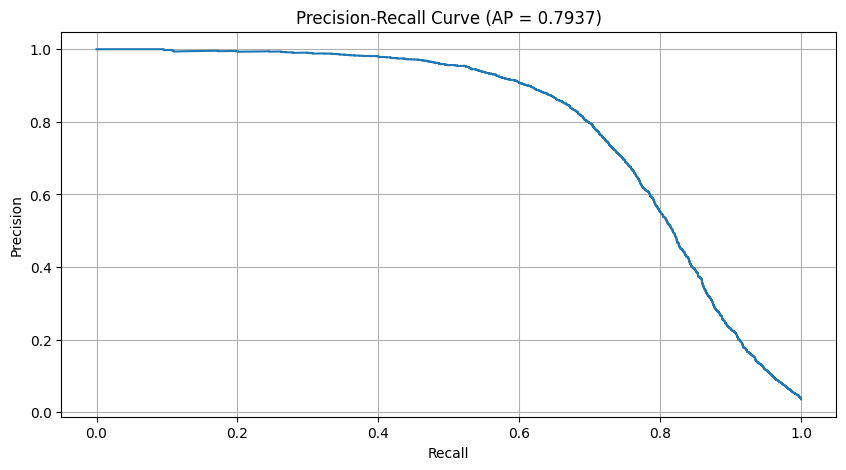

ALL PLOTS SAVED!
 - curve_auc.png
 - curve_logloss.png
 - feature_importance.png
 - precision_recall.png


In [5]:
import os
import pandas as pd
import lightgbm as lgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

print("Loading data...")

# Auto-detect Kaggle environment
if os.path.exists("/kaggle/input"):
    TRAIN_TRANS = "/kaggle/input/ieee-fraud-detection/train_transaction.csv"
    TRAIN_IDENT = "/kaggle/input/ieee-fraud-detection/train_identity.csv"
else:
    TRAIN_TRANS = "train_transaction.csv"
    TRAIN_IDENT = "train_identity.csv"

train_tr = pd.read_csv(TRAIN_TRANS, index_col="TransactionID")
train_id = pd.read_csv(TRAIN_IDENT, index_col="TransactionID")

train = train_tr.merge(train_id, how="left", left_index=True, right_index=True)

# target
y = train["isFraud"]
X = train.drop("isFraud", axis=1)

# ---------------------------
#  Feature list
# ---------------------------
new_features = [
    "TransactionID", "TransactionAmt", "DeviceInfo", "TransactionDT",
    "ProductCD", "card1", "card2", "card3", "card4", "card5", "card6",
    "addr1", "addr2", "dist1", "dist2", "P_emaildomain", "R_emaildomain"
]
features = [f for f in new_features if f in X.columns]
X = X[features]

# ---------------------------
# Fill NA
# ---------------------------
X = X.fillna(-999)

# ---------------------------
# Label Encoding
# ---------------------------
label_encoders = {}
for col in X.columns:
    if X[col].dtype == "object":
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(features, "model_features.pkl")

# ---------------------------
# Train/Val Split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# LightGBM Model
# ---------------------------
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_val, label=y_val)

evals_result = {}  # dictionary to store evaluation results

params = {
    "objective": "binary",
    "metric": ["auc", "binary_logloss"],
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 128,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "verbosity": -1,
}

model = lgb.train(
    params,
    train_ds,
    valid_sets=[train_ds, val_ds],
    valid_names=["train", "valid"],
    num_boost_round=3000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200),
        lgb.record_evaluation(evals_result)  # <-- store metrics here
    ]
)

model.save_model("ieee_lgbm.txt")
joblib.dump(evals_result, "evals_result.pkl")

# ---------------------------
# Evaluate Validation AUC
# ---------------------------
val_pred = model.predict(X_val)
auc = roc_auc_score(y_val, val_pred)
print("Validation AUC:", auc)

# ============================================================
# 1. TRAINING vs VALIDATION AUC CURVE
# ============================================================
plt.figure(figsize=(10, 5))
plt.plot(evals_result["train"]["auc"], label="Train AUC")
plt.plot(evals_result["valid"]["auc"], label="Validation AUC")
plt.title("AUC Curve")
plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.savefig("curve_auc.png", dpi=300)
plt.show()

# ============================================================
# 2. TRAINING vs VALIDATION LOGLOSS CURVE
# ============================================================
plt.figure(figsize=(10, 5))
plt.plot(evals_result["train"]["binary_logloss"], label="Train Logloss")
plt.plot(evals_result["valid"]["binary_logloss"], label="Valid Logloss")
plt.title("Logloss Curve")
plt.xlabel("Iterations")
plt.ylabel("Logloss")
plt.legend()
plt.grid(True)
plt.savefig("curve_logloss.png", dpi=300)
plt.show()

# ============================================================
# 3. FEATURE IMPORTANCE
# ============================================================
importance = model.feature_importance(importance_type="gain")
indices = np.argsort(importance)[::-1]
feat_names_sorted = X.columns[indices]

plt.figure(figsize=(10, 7))
plt.barh(feat_names_sorted, importance[indices])
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

# ============================================================
# 4. PRECISION–RECALL CURVE
# ============================================================
precision, recall, thresholds = precision_recall_curve(y_val, val_pred)
ap = average_precision_score(y_val, val_pred)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.savefig("precision_recall.png", dpi=300)
plt.show()

print("ALL PLOTS SAVED!")
print(" - curve_auc.png")
print(" - curve_logloss.png")
print(" - feature_importance.png")
print(" - precision_recall.png")
